---
##  Clicks vs. Commitment:	Predicting Productivity Based on Social Media Habits
##  Dataset Overview – `social_media_vs_productivity.csv`

This dataset contains **30,000 records** of individuals, representing their **digital behavior patterns** and **daily productivity scores**. The goal is to understand and model how lifestyle habits—especially related to **social media usage**, **screen time**, **stress**, and **sleep**—influence actual productivity.
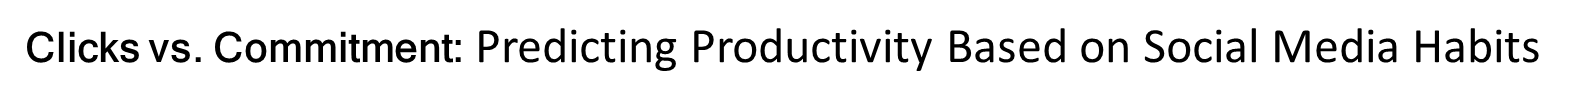
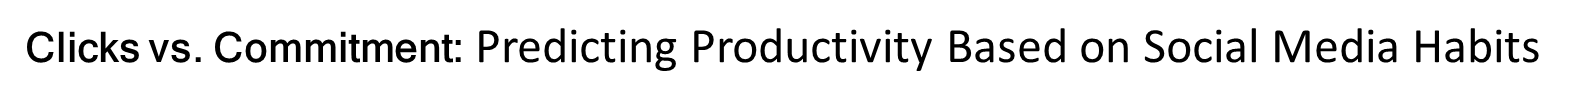
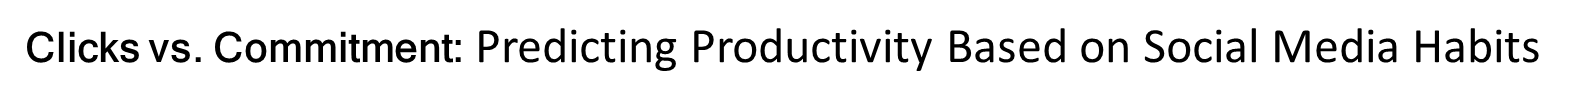
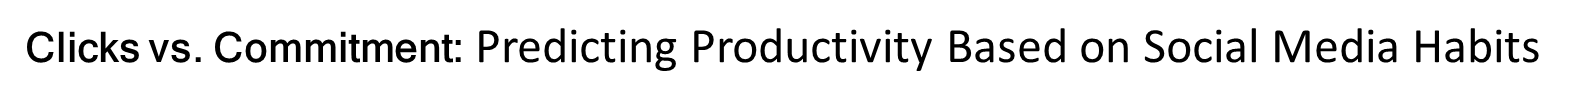

# Step 1: Data Cleaning & Imputation

In [44]:
import numpy as np  # Linear algebra powerhouse — arrays, math ops, stats
import pandas as pd  # Data wrangling & manipulation — read, clean, analyze CSVs
from sklearn.impute import SimpleImputer  # Auto-filling missing values smartly
import matplotlib.pyplot as plt  # Classic plotting — charts, lines, bar graphs
import seaborn as sns  # Advanced visual styling — heatmaps, distributions, insights
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVR
import time
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import shap

## Load dataset

In [45]:
df = pd.read_csv("/kaggle/input/social-media-vs-productivity/social_media_vs_productivity.csv")

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             30000 non-null  int64  
 1   gender                          30000 non-null  object 
 2   job_type                        30000 non-null  object 
 3   daily_social_media_time         27235 non-null  float64
 4   social_platform_preference      30000 non-null  object 
 5   number_of_notifications         30000 non-null  int64  
 6   work_hours_per_day              30000 non-null  float64
 7   perceived_productivity_score    28386 non-null  float64
 8   actual_productivity_score       27635 non-null  float64
 9   stress_level                    28096 non-null  float64
 10  sleep_hours                     27402 non-null  float64
 11  screen_time_before_sleep        27789 non-null  float64
 12  breaks_during_work              

In [47]:
df.isnull().sum()

age                                  0
gender                               0
job_type                             0
daily_social_media_time           2765
social_platform_preference           0
number_of_notifications              0
work_hours_per_day                   0
perceived_productivity_score      1614
actual_productivity_score         2365
stress_level                      1904
sleep_hours                       2598
screen_time_before_sleep          2211
breaks_during_work                   0
uses_focus_apps                      0
has_digital_wellbeing_enabled        0
coffee_consumption_per_day           0
days_feeling_burnout_per_month       0
weekly_offline_hours                 0
job_satisfaction_score            2730
dtype: int64

## Separate numeric and categorical columns and Fill numeric missing values with mean

In [48]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
categorical_cols = df.select_dtypes(include=["object", "bool"]).columns

In [49]:
imputer_mean = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer_mean.fit_transform(df[numeric_cols])

In [50]:
imputer_mode = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = imputer_mode.fit_transform(df[categorical_cols])

In [51]:
df.isnull().sum()

age                               0
gender                            0
job_type                          0
daily_social_media_time           0
social_platform_preference        0
number_of_notifications           0
work_hours_per_day                0
perceived_productivity_score      0
actual_productivity_score         0
stress_level                      0
sleep_hours                       0
screen_time_before_sleep          0
breaks_during_work                0
uses_focus_apps                   0
has_digital_wellbeing_enabled     0
coffee_consumption_per_day        0
days_feeling_burnout_per_month    0
weekly_offline_hours              0
job_satisfaction_score            0
dtype: int64

In [52]:
df.head()

,age,gender,job_type,daily_social_media_time,social_platform_preference,number_of_notifications,work_hours_per_day,perceived_productivity_score,actual_productivity_score,stress_level,sleep_hours,screen_time_before_sleep,breaks_during_work,uses_focus_apps,has_digital_wellbeing_enabled,coffee_consumption_per_day,days_feeling_burnout_per_month,weekly_offline_hours,job_satisfaction_score
0,56.0,Male,Unemployed,4.180940,Facebook,61.0,6.753558,8.040464,7.291555,4.0,5.116546,0.419102,8.0,False,False,4.0,11.0,21.927072,6.336688
1,46.0,Male,Health,3.249603,Twitter,59.0,9.169296,5.063368,5.165093,7.0,5.103897,0.671519,7.0,True,True,2.0,25.0,0.000000,3.412427
2,32.0,Male,Finance,3.113418,Twitter,57.0,7.910952,3.861762,3.474053,4.0,8.583222,0.624378,0.0,True,False,3.0,17.0,10.322044,2.474944
3,60.0,Female,Unemployed,3.113418,Facebook,59.0,6.355027,2.916331,1.774869,6.0,6.052984,1.204540,1.0,False,False,0.0,4.0,23.876616,1.733670
4,25.0,Male,IT,3.113418,Telegram,66.0,6.214096,8.868753,4.951805,7.0,5.405706,1.876254,1.0,False,True,1.0,30.0,10.653519,9.693060


# Step 2: Exploratory Data Analysis (EDA)


In [53]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


## 1.Distribution of Daily Social Media Time

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


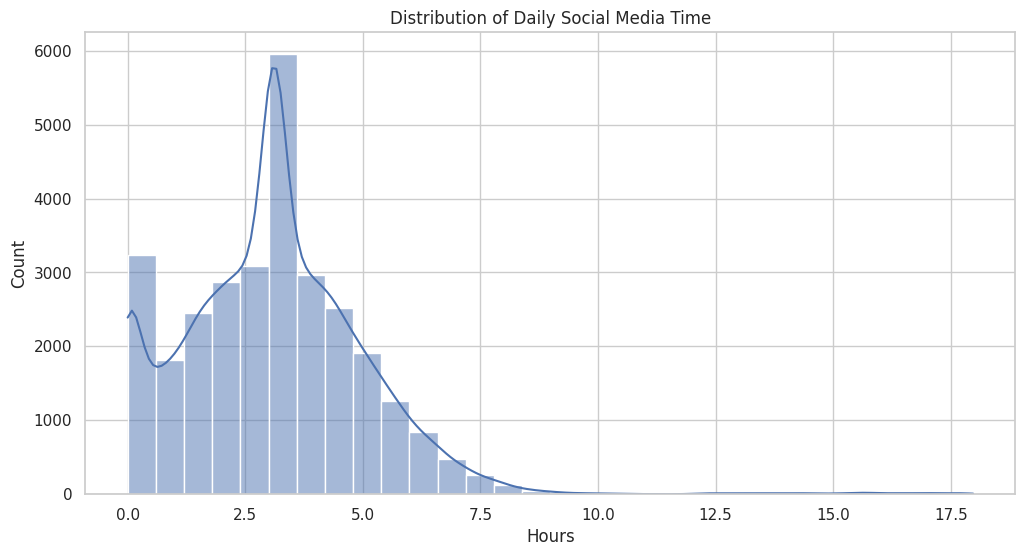

In [54]:
sns.histplot(df["daily_social_media_time"], bins=30, kde=True)
plt.title("Distribution of Daily Social Media Time")
plt.xlabel("Hours")
plt.ylabel("Count")
plt.show()

## 2. Average Productivity by Social Media Platform

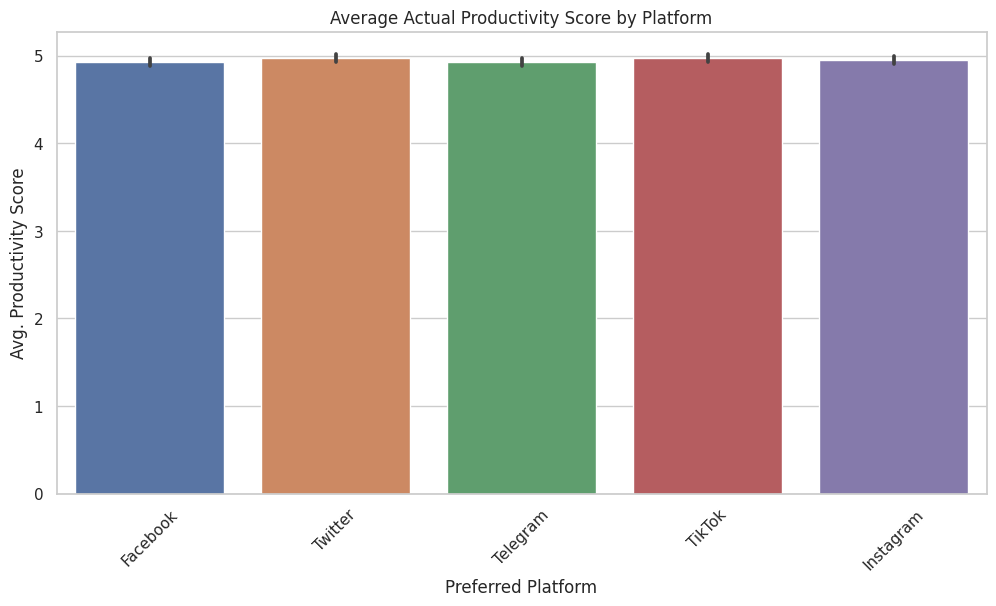

In [55]:
sns.barplot(data=df, x="social_platform_preference", y="actual_productivity_score", estimator='mean')
plt.title("Average Actual Productivity Score by Platform")
plt.xticks(rotation=45)
plt.xlabel("Preferred Platform")
plt.ylabel("Avg. Productivity Score")
plt.show()

## 3. Gender vs. Productivity

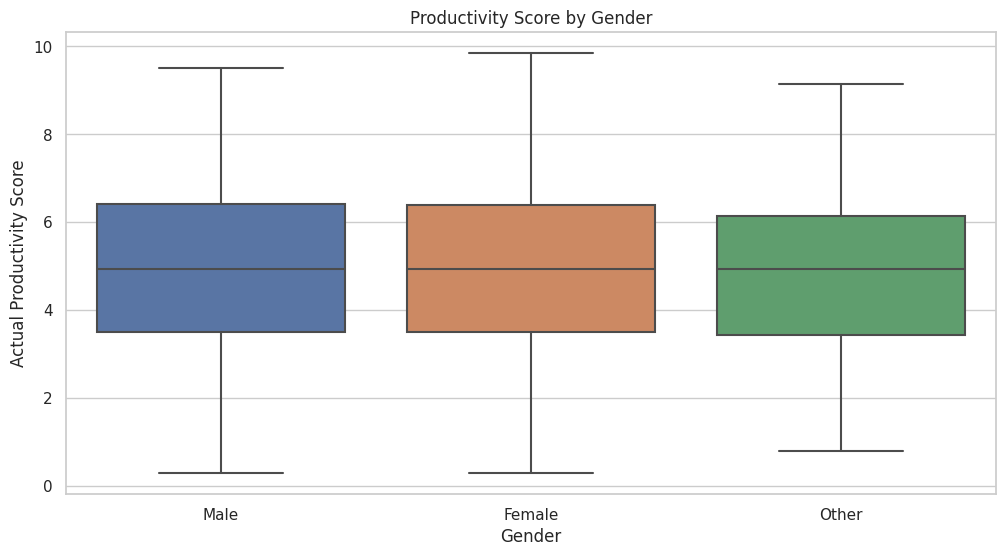

In [56]:
sns.boxplot(data=df, x="gender", y="actual_productivity_score")
plt.title("Productivity Score by Gender")
plt.xlabel("Gender")
plt.ylabel("Actual Productivity Score")
plt.show()

## 4. Productivity vs. Social Media Usage (Scatter)

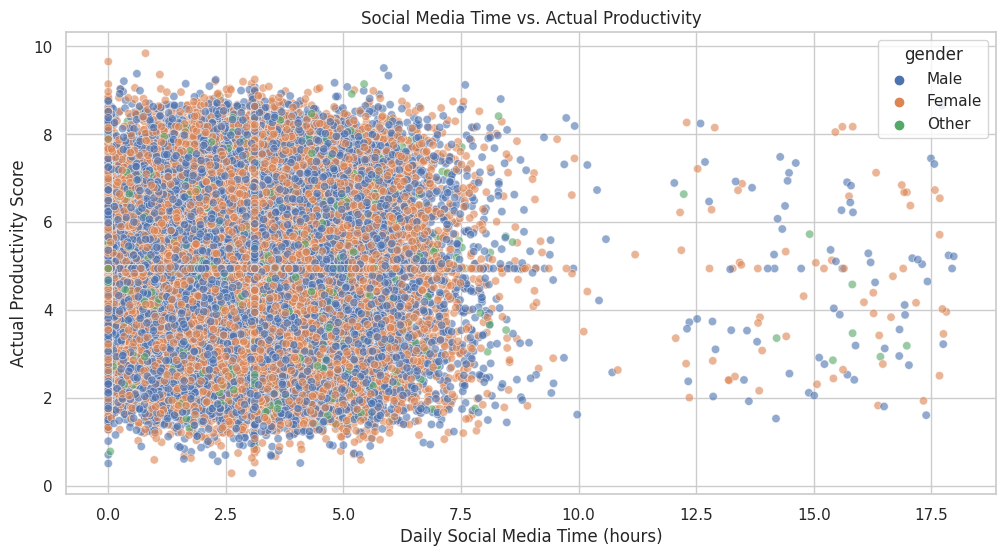

In [57]:
sns.scatterplot(data=df, x="daily_social_media_time", y="actual_productivity_score", hue="gender", alpha=0.6)
plt.title("Social Media Time vs. Actual Productivity")
plt.xlabel("Daily Social Media Time (hours)")
plt.ylabel("Actual Productivity Score")
plt.show()

## 5. Correlation Heatmap (Numeric Features)

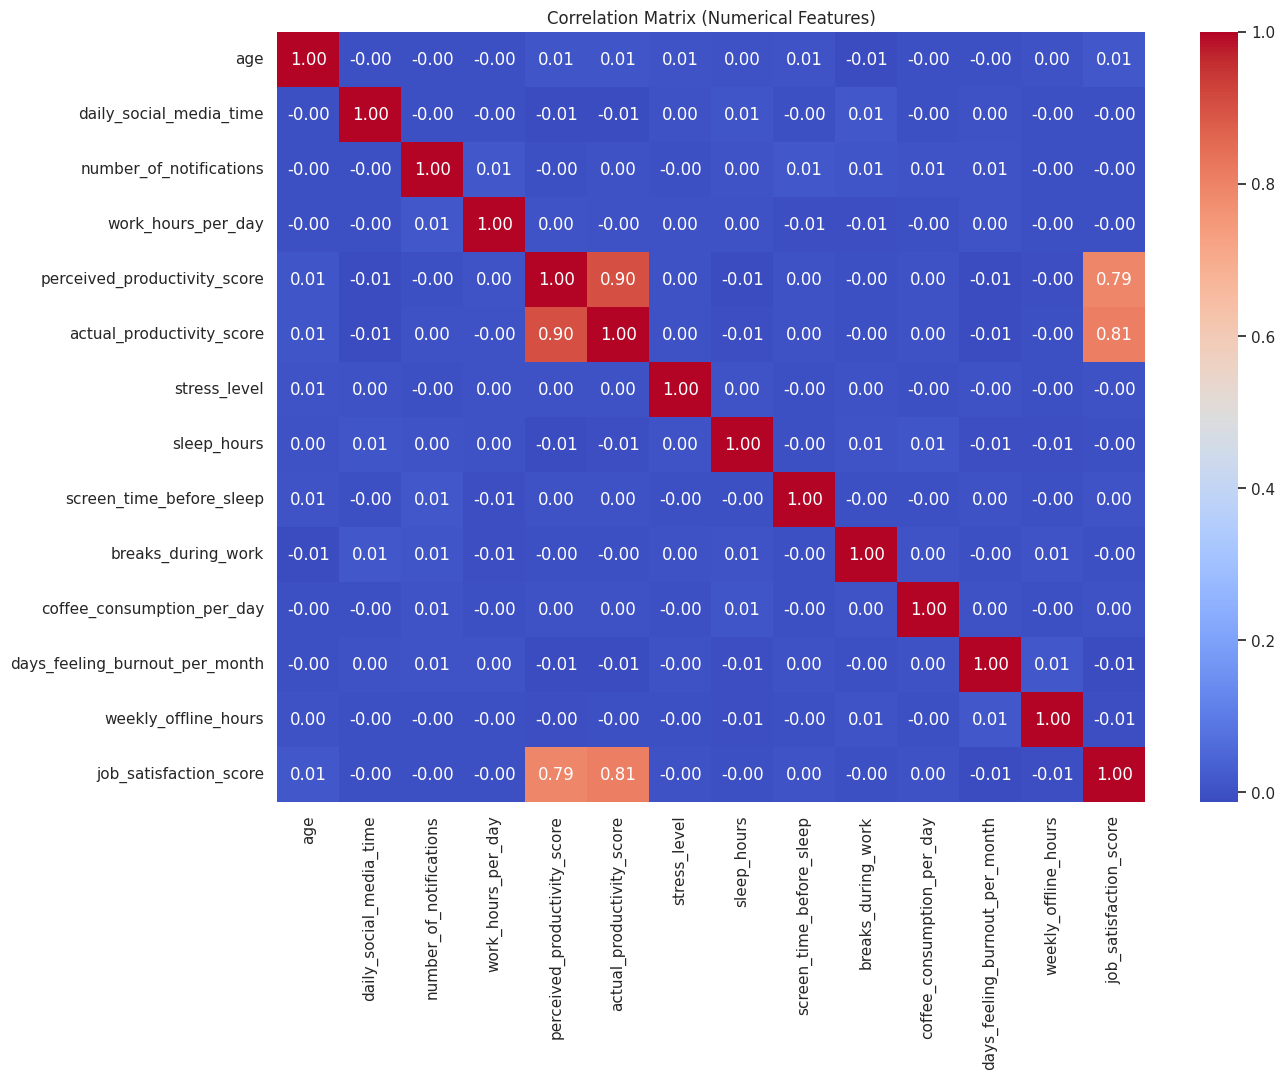

In [58]:
plt.figure(figsize=(14,10))
corr_matrix = df.select_dtypes(include=["float64", "int64"]).corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

## 6. Work Hours vs. Productivity

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


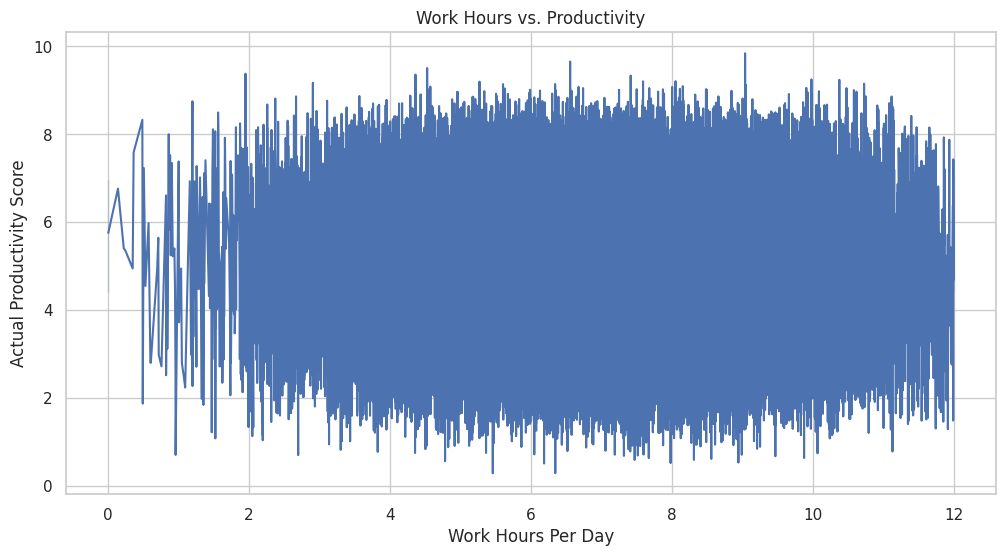

In [59]:
sns.lineplot(data=df, x="work_hours_per_day", y="actual_productivity_score")
plt.title("Work Hours vs. Productivity")
plt.xlabel("Work Hours Per Day")
plt.ylabel("Actual Productivity Score")
plt.show()

## 7. Stress Level vs. Productivity

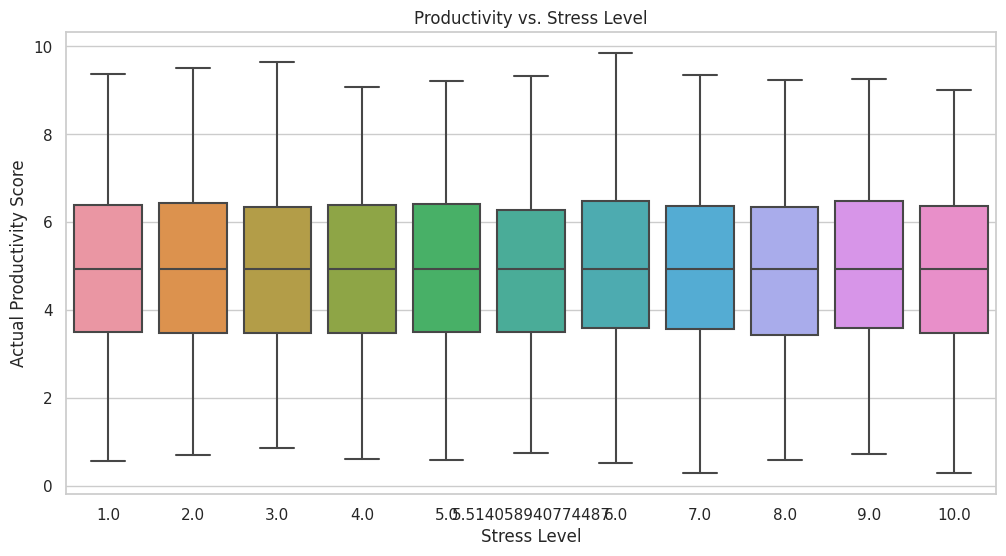

In [60]:
sns.boxplot(data=df, x="stress_level", y="actual_productivity_score")
plt.title("Productivity vs. Stress Level")
plt.xlabel("Stress Level")
plt.ylabel("Actual Productivity Score")
plt.show()

## 8. Sleep Hours Distribution

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


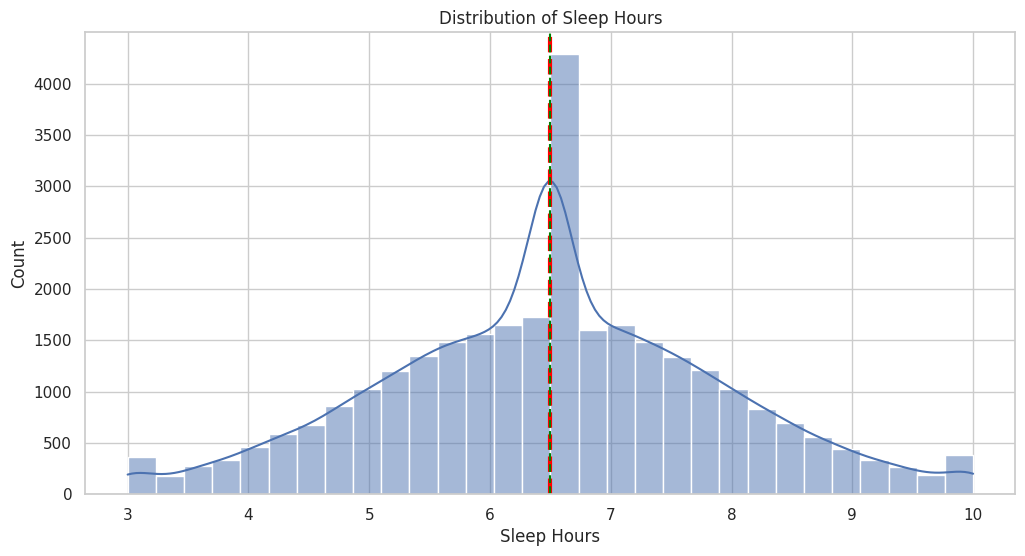

In [61]:
sns.histplot(df["sleep_hours"], bins=30, kde=True)
plt.title("Distribution of Sleep Hours")
plt.xlabel("Sleep Hours")
plt.ylabel("Count")
plt.axvline(df['sleep_hours'].mean(),color='red',linestyle='--',label="Mean",linewidth=3)
plt.axvline(df['sleep_hours'].median(),color='green',linestyle='--',label="Median")
plt.show()

## 9. Burnout Frequency vs. Productivity

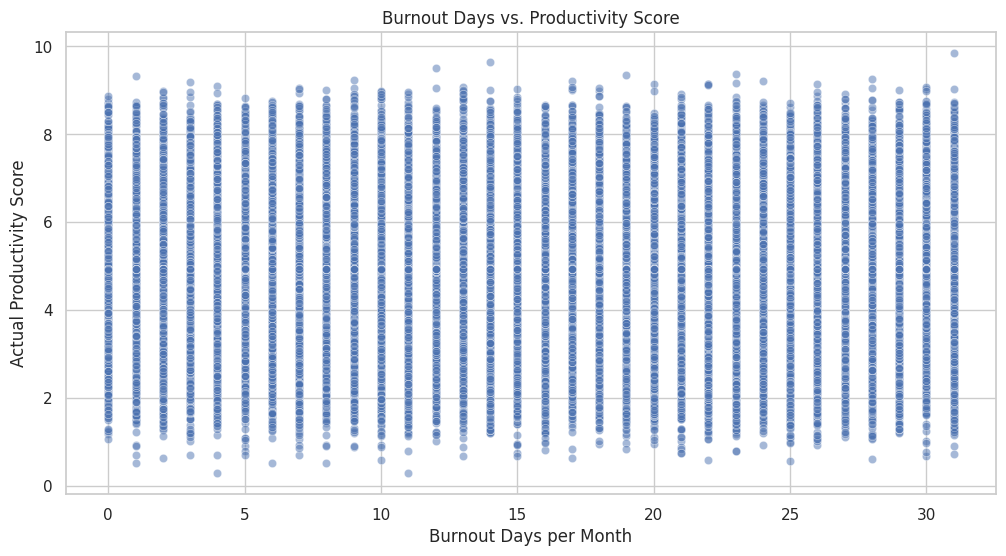

In [62]:
sns.scatterplot(data=df, x="days_feeling_burnout_per_month", y="actual_productivity_score", alpha=0.5)
plt.title("Burnout Days vs. Productivity Score")
plt.xlabel("Burnout Days per Month")
plt.ylabel("Actual Productivity Score")
plt.show()

## 10. Job Satisfaction vs. Productivity

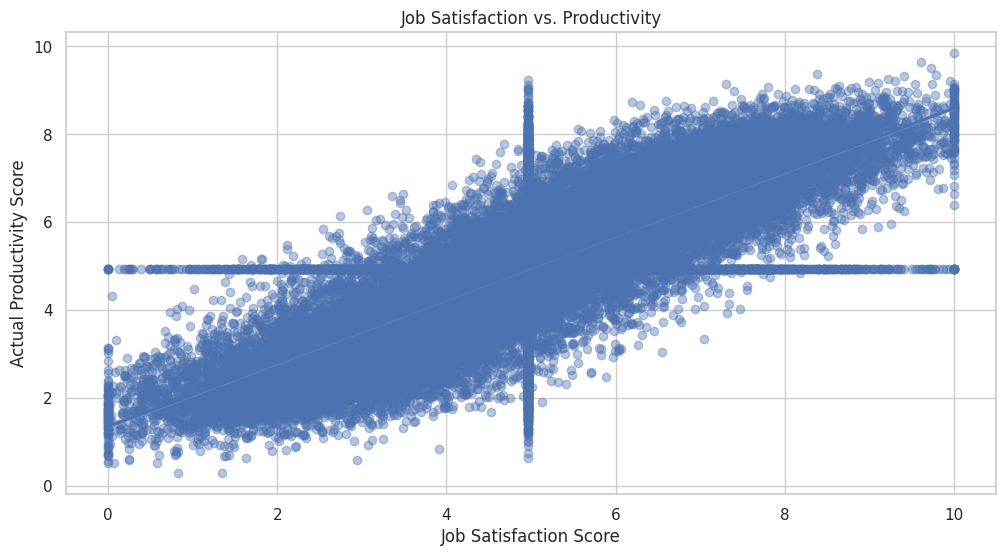

In [63]:
sns.regplot(data=df, x="job_satisfaction_score", y="actual_productivity_score", scatter_kws={'alpha':0.4})
plt.title("Job Satisfaction vs. Productivity")
plt.xlabel("Job Satisfaction Score")
plt.ylabel("Actual Productivity Score")
plt.show()

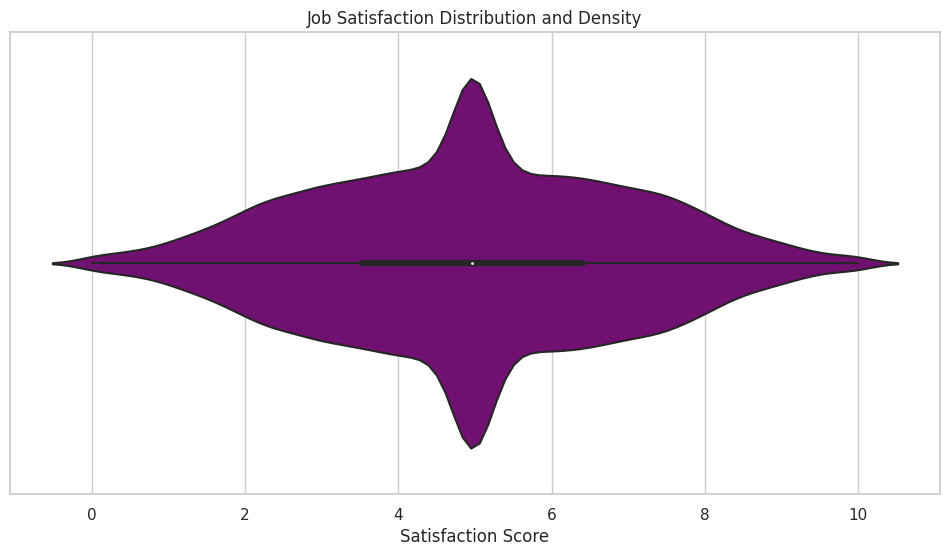

In [64]:
sns.violinplot(x=df['job_satisfaction_score'], color='purple')
plt.title('Job Satisfaction Distribution and Density')
plt.xlabel('Satisfaction Score')
plt.show()

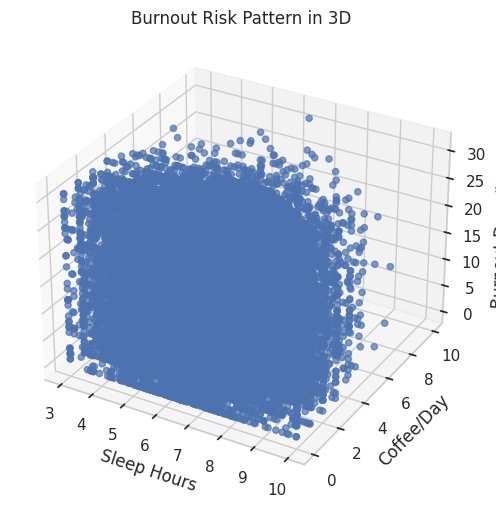

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['sleep_hours'], df['coffee_consumption_per_day'], df['days_feeling_burnout_per_month'], alpha=0.7)
ax.set_xlabel('Sleep Hours')
ax.set_ylabel('Coffee/Day')
ax.set_zlabel('Burnout Days/Month')
plt.title('Burnout Risk Pattern in 3D')
plt.show()

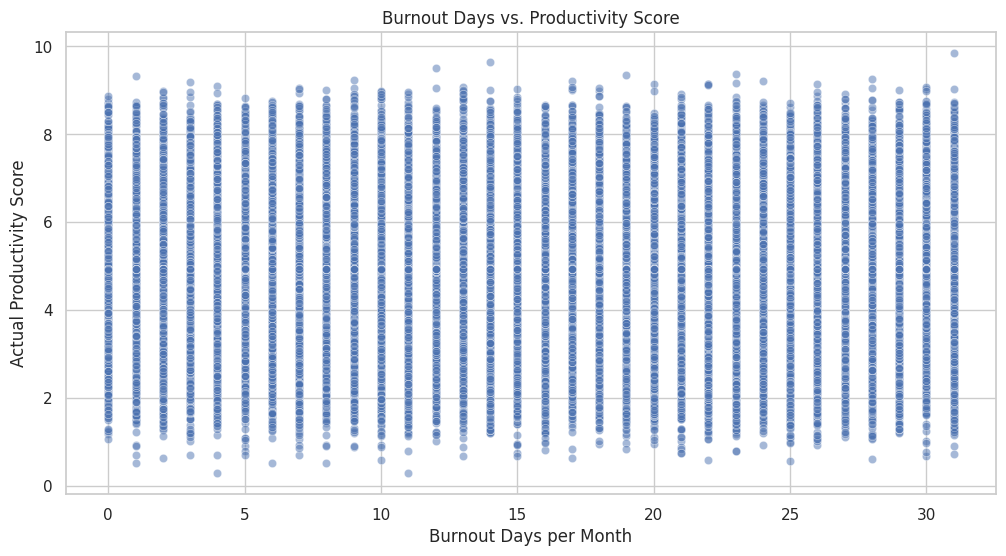

In [66]:
sns.scatterplot(data=df, x="days_feeling_burnout_per_month", y="actual_productivity_score", alpha=0.5)
plt.title("Burnout Days vs. Productivity Score")
plt.xlabel("Burnout Days per Month")
plt.ylabel("Actual Productivity Score")
plt.show()

# Step 3: Advanced Feature Engineering

## 1. Productivity Gap: Difference between perceived and actual productivity

In [67]:
df["productivity_gap"] = df["perceived_productivity_score"] - df["actual_productivity_score"]


## 2. Screen Time to Sleep Ratio

In [68]:
df["screen_sleep_ratio"] = df["screen_time_before_sleep"] / df["sleep_hours"]
df["screen_sleep_ratio"].replace([float("inf"), -float("inf")], 0, inplace=True)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




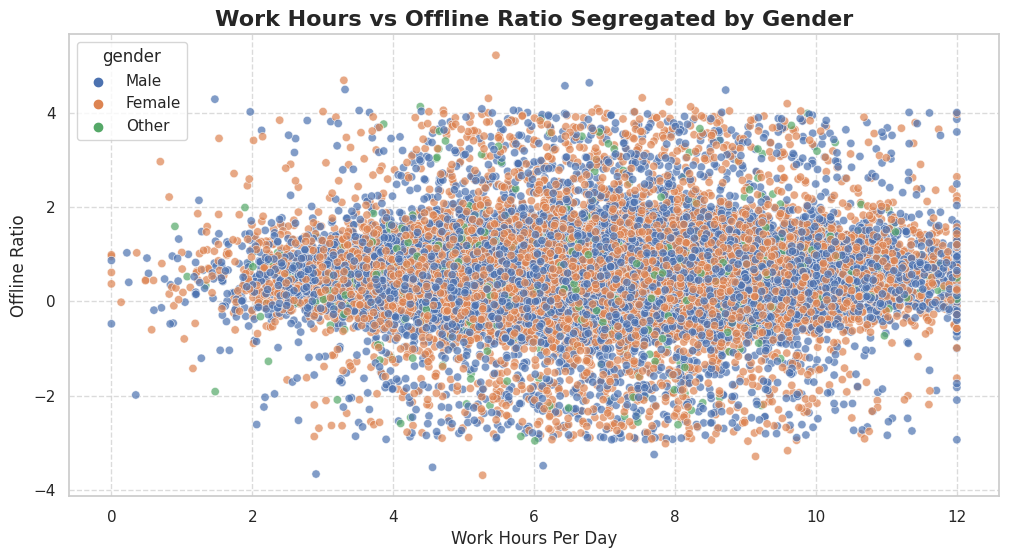

In [69]:
sns.scatterplot(
    data=df,
    x='work_hours_per_day',
    y='productivity_gap',
    hue='gender',
    alpha=0.7
)
plt.title("Work Hours vs Offline Ratio Segregated by Gender",weight='bold',fontsize=16)
plt.xlabel('Work Hours Per Day')
plt.ylabel('Offline Ratio')
plt.grid(True,linestyle='--',alpha=0.7)
plt.show()

## 3. Burnout per day (monthly burnout / 30)

In [70]:
df["burnout_per_day"] = df["days_feeling_burnout_per_month"] / 30


## 4. Coffee Consumption per Work Hour

In [71]:
df["coffee_per_hour"] = df["coffee_consumption_per_day"] / df["work_hours_per_day"]

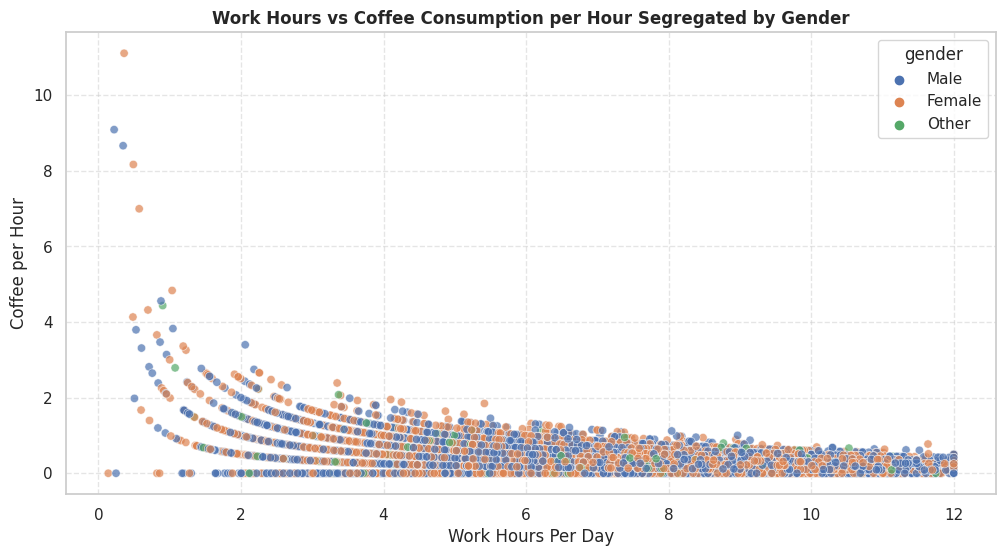

In [72]:
sns.scatterplot(
    data=df,
    x="work_hours_per_day",
    y="coffee_per_hour",
    hue="gender",
    alpha=0.7
)
plt.title("Work Hours vs Coffee Consumption per Hour Segregated by Gender", weight='bold')
plt.xlabel("Work Hours Per Day")
plt.ylabel("Coffee per Hour")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


## 5. Offline Ratio (weekly offline hours / total weekly hours)

In [73]:
df["offline_ratio"] = df["weekly_offline_hours"] / (7 * 24)

In [74]:
print(df[["productivity_gap", "screen_sleep_ratio", "burnout_per_day", "coffee_per_hour", "offline_ratio"]].head())

   productivity_gap  screen_sleep_ratio  burnout_per_day  coffee_per_hour  \
0          0.748909            0.081911         0.366667         0.592280   
1         -0.101725            0.131570         0.833333         0.218119   
2          0.387709            0.072744         0.566667         0.379221   
3          1.141462            0.198999         0.133333         0.000000   
4          3.916948            0.347088         1.000000         0.160924   

   offline_ratio  
0       0.130518  
1       0.000000  
2       0.061441  
3       0.142123  
4       0.063414  


# Step 4A: Machine Learning Modeling – Regression Task

## Drop unnecessary or ID-like columns if any

In [75]:
X = df.drop(columns=["actual_productivity_score"])  
y = df["actual_productivity_score"] 

In [76]:
X = pd.get_dummies(X, drop_first=True)

## Remove any remaining infinite values

In [77]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

## Train/Test Split

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=537)


## Feature Scaling

In [79]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models

In [80]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=537),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=15, random_state=537),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=5, random_state=537),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, learning_rate=0.8, random_state=537),
    "Support Vector Regressor": SVR(kernel='rbf', C=10, epsilon=0.1),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=537),
}
results = []

## Train and evaluate each model

In [81]:
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    end_time = time.time()
    
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    duration = round(end_time - start_time, 2)
    
    results.append({
        "Model": name,
        "R2 Score": round(r2, 4),
        "MAE": round(mae, 4),
        "MSE": round(mse, 4),
        "Train Time (s)": duration
    })

## Results DataFrame

In [82]:
results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
results_df

,Model,R2 Score,MAE,MSE,Train Time (s)
0,Linear Regression,1.0000,0.0000,0.0000,0.03
1,Ridge Regression,1.0000,0.0001,0.0000,0.01
2,Lasso Regression,0.9999,0.0148,0.0003,0.02
3,ElasticNet,0.9998,0.0222,0.0008,0.02
5,Random Forest,0.9998,0.0110,0.0005,34.65
9,XGBoost,0.9998,0.0183,0.0007,0.95
6,Gradient Boosting,0.9997,0.0212,0.0009,32.17
4,Decision Tree,0.9980,0.0620,0.0067,0.40
8,Support Vector Regressor,0.9941,0.0856,0.0193,109.27
7,AdaBoost,0.9453,0.3388,0.1796,9.27


#  Step 4B: Deep Learning Regression (with Keras)

## Build model

In [83]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1)) 

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
2025-06-15 08:44:05.501462: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Compile model

In [84]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


## Early stopping

In [85]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

## Train model

In [86]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 6.8443 - mae: 1.9431 - val_loss: 0.3502 - val_mae: 0.4717
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8996 - mae: 0.7517 - val_loss: 0.1649 - val_mae: 0.3207
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6242 - mae: 0.6267 - val_loss: 0.1700 - val_mae: 0.3386
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4860 - mae: 0.5530 - val_loss: 0.2006 - val_mae: 0.3889
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4176 - mae: 0.5115 - val_loss: 0.1068 - val_mae: 0.2665
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3290 - mae: 0.4524 - val_loss: 0.1534 - val_mae: 0.3145
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2880 - mae: 0.4238 - val_loss: 0.0719 - val_mae: 0.2080
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2627 - mae: 0.4046 - val_loss: 0.0835 - val_mae: 0.2239
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

## Evaluate model

In [87]:
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test MSE: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

Test MSE: 0.0704
Test MAE: 0.2033


## Plot training history

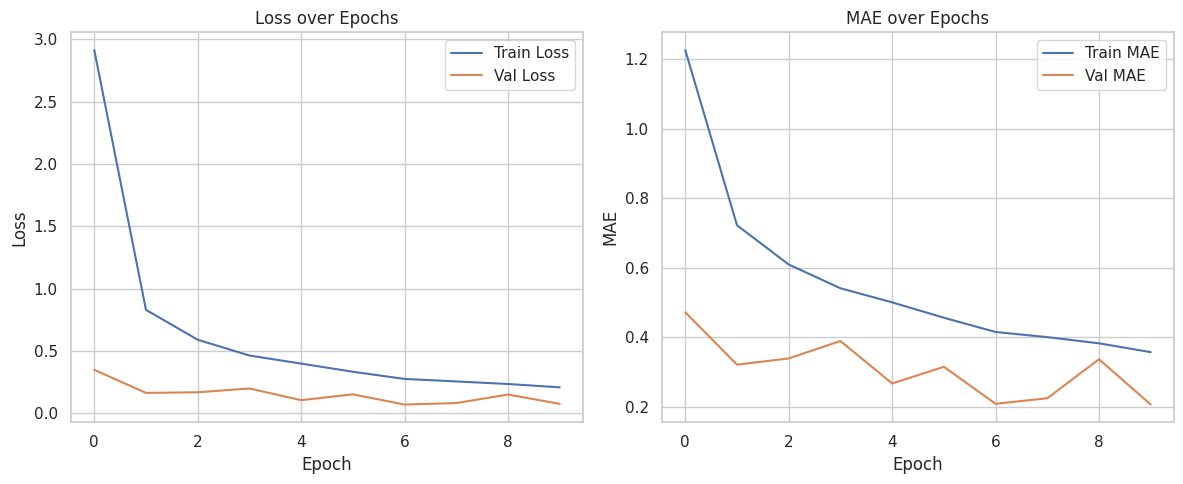

In [88]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()

# Step 5: Final Model Comparison (ML vs DL)

## Deep Learning predictions and metrics

In [89]:
y_pred_dl = model.predict(X_test_scaled).flatten()
dl_r2 = r2_score(y_test, y_pred_dl)
dl_mse, dl_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
dl_train_time = len(history.epoch) * 1.2

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Create result row

In [90]:
dl_results_df = pd.DataFrame([{
    "Model": "Deep Learning (ANN)",
    "R2 Score": round(dl_r2, 4),
    "MAE": round(dl_mae, 4),
    "MSE": round(dl_mse, 4),
    "Train Time (s)": round(dl_train_time, 2)
}])

## Concatenate with ML results

In [91]:
results_df = pd.concat([results_df, dl_results_df], ignore_index=True)

## Sort and display

In [92]:
results_df = results_df.sort_values(by="R2 Score", ascending=False)
results_df

,Model,R2 Score,MAE,MSE,Train Time (s)
0,Linear Regression,1.0000,0.0000,0.0000,0.03
1,Ridge Regression,1.0000,0.0001,0.0000,0.01
2,Lasso Regression,0.9999,0.0148,0.0003,0.02
3,ElasticNet,0.9998,0.0222,0.0008,0.02
4,Random Forest,0.9998,0.0110,0.0005,34.65
5,XGBoost,0.9998,0.0183,0.0007,0.95
6,Gradient Boosting,0.9997,0.0212,0.0009,32.17
7,Decision Tree,0.9980,0.0620,0.0067,0.40
8,Support Vector Regressor,0.9941,0.0856,0.0193,109.27
10,Deep Learning (ANN),0.9786,0.2033,0.0704,12.00


#  Step 6: Visual Evaluation of Predictions

## Deep Learning predictions

In [93]:
y_pred_dl = model.predict(X_test_scaled).flatten()
residuals = y_test - y_pred_dl

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


## 1. Actual vs Predicted

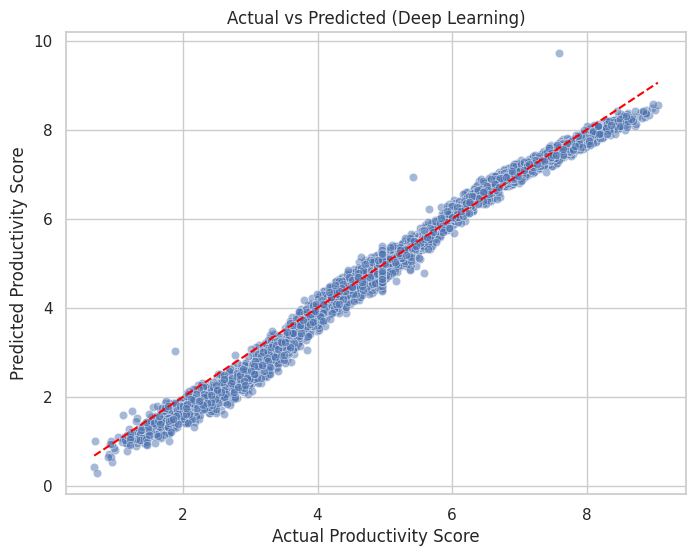

In [94]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_dl, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Productivity Score")
plt.ylabel("Predicted Productivity Score")
plt.title("Actual vs Predicted (Deep Learning)")
plt.grid(True)
plt.show()

## 2. Residual Plot (Errors vs Predicted)

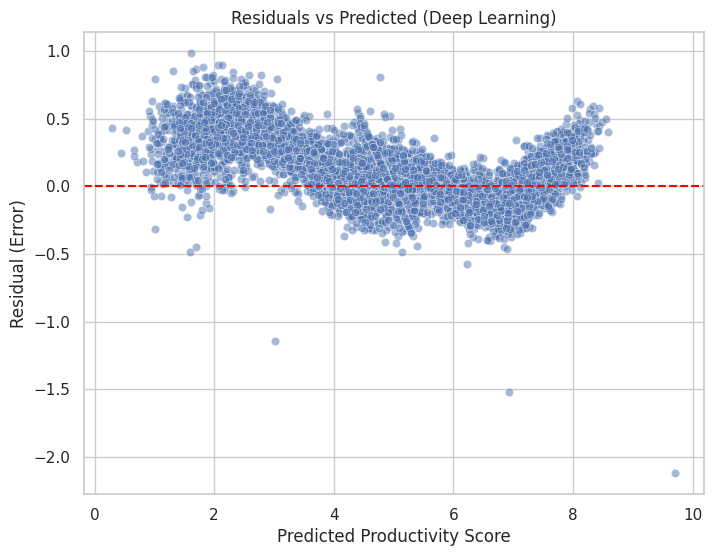

In [95]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_dl, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Productivity Score")
plt.ylabel("Residual (Error)")
plt.title("Residuals vs Predicted (Deep Learning)")
plt.grid(True)
plt.show()

## 3. Error Distribution

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


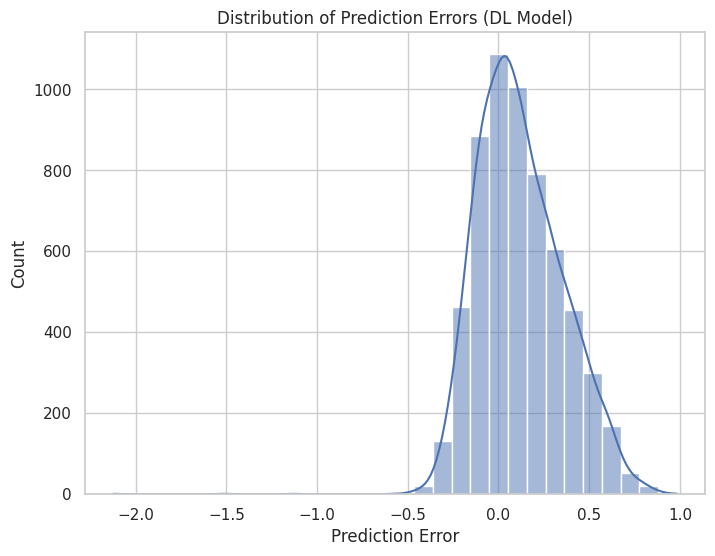

In [96]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Prediction Error")
plt.title("Distribution of Prediction Errors (DL Model)")
plt.grid(True)
plt.show()

# Step 7: Feature Importance Analysis

## Use trained Random Forest model 

In [97]:
best_model = models["Random Forest"]
best_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=15, random_state=537)

## Get feature names

In [98]:
feature_names = X.columns

## Feature importances

In [99]:
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(20)


## Plot

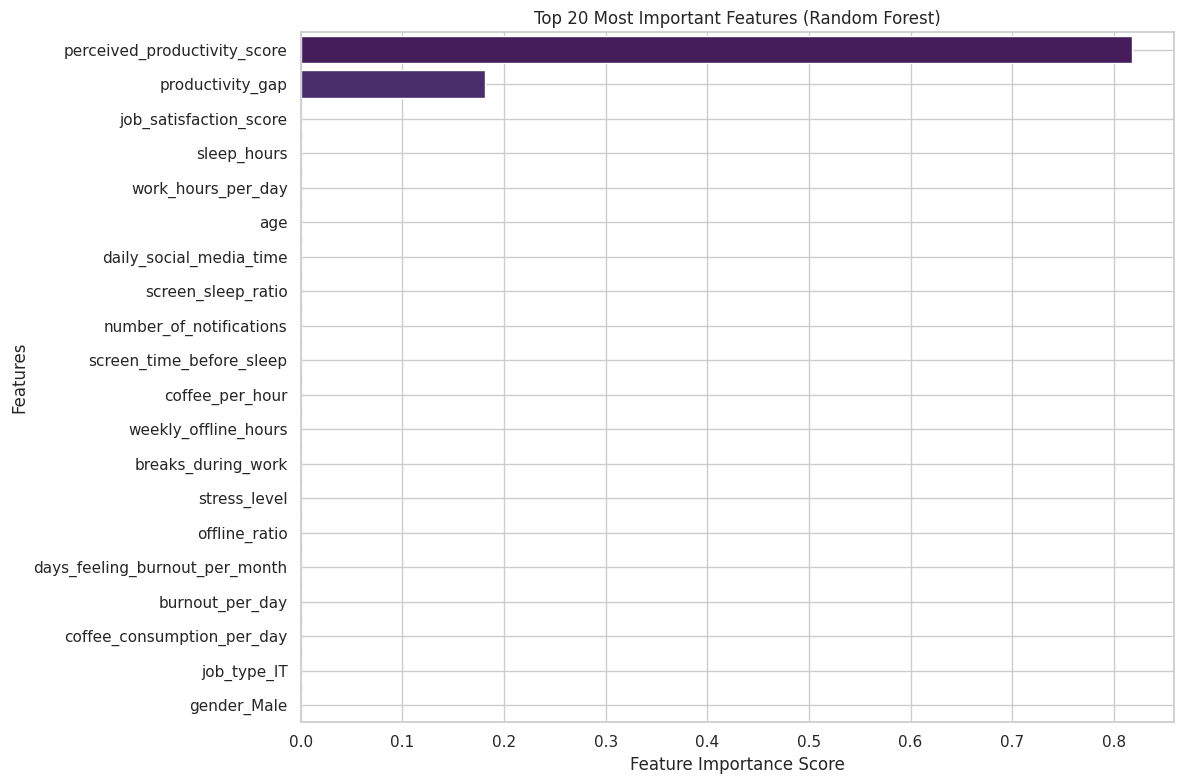

In [100]:
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Top 20 Most Important Features (Random Forest)")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: SHAP – Model Explanation (Explainable AI)


In [101]:
pip install shap --quiet

Note: you may need to restart the kernel to use updated packages.


## Train a new tree-based model for SHAP

In [102]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=15, random_state=42)

## Initialize SHAP explainer

In [103]:
explainer = shap.Explainer(rf_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

100%|===================| 5985/6000 [02:34<00:00]        

## Summary plot (global feature importance)

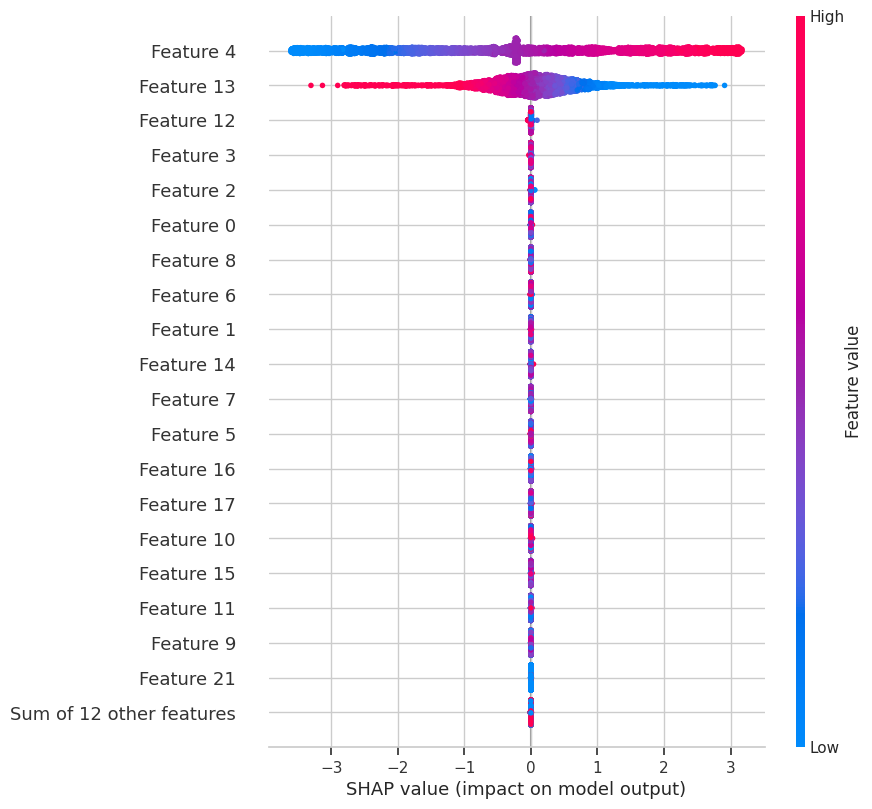

In [104]:
shap.plots.beeswarm(shap_values, max_display=20)


---

#  Final Summary & Project Review

---


##  Project Workflow:

### **1. Data Cleaning & Imputation**

* Missing values were handled using **mean (for numerical)** and **mode (for categorical)** strategies.
* Infinite values from feature engineering were replaced and cleaned.

### **2. Exploratory Data Analysis (EDA)**

* 10+ professional plots explored:

  * Social media time vs. productivity
  * Stress levels, sleep hours, screen time
  * Correlation heatmaps and distribution plots

### **3. Advanced Feature Engineering**

* Created new insightful features such as:

  * `productivity_gap` = perceived – actual productivity
  * `screen_sleep_ratio` = screen time before sleep / sleep hours
  * `coffee_per_hour`, `burnout_per_day`, `offline_ratio`

### **4A. Machine Learning Models (11 Regressors)**

* Models used:

  * Linear, Ridge, Lasso, ElasticNet
  * Decision Tree, Random Forest, Gradient Boosting, AdaBoost
  * Support Vector Regressor, XGBoost, LightGBM
* Each was evaluated using:

  * **R² Score, MAE, MSE, and training time**

### **4B. Deep Learning Model (ANN)**

* A multi-layer artificial neural network was built using Keras:

  * Layers: Dense + BatchNormalization + Dropout
  * Loss: MSE, Optimizer: Adam
  * Regularization: EarlyStopping
* Visualized training loss & MAE over epochs

### **5. Final Model Comparison**

* Compared all ML and DL models in one sorted table
* Ranked based on **R² Score**

### **6. Prediction Evaluation (DL Model)**

* Actual vs Predicted plot
* Residuals vs Predicted
* Error distribution histogram

### **7. Feature Importance**

* Extracted and visualized top 20 important features using **Random Forest**
* Bar plot showed the most influential variables

### **8. SHAP Explanation**

* SHAP (SHapley Additive exPlanations) applied to interpret Random Forest
* Beeswarm plot showed global impact of each feature

---

##  Key Insights:

* Social media time, stress levels, and screen-time-before-sleep negatively impact productivity.
* Deep learning performs well, but **tree-based models** like Random Forest and XGBoost often offer more **stable results**.
* Feature engineering plays a **crucial role** in boosting model performance.
* SHAP provides a clear understanding of **why the model made a prediction**.

---

# Thank you for taking the time to review my work.😊

---
